In [6]:
# You don't need to run this cell if you don't have the package installed - it's useful for documenting version numbers
%load_ext watermark


ModuleNotFoundError: No module named 'watermark'

In [8]:
# You don't need to run this cell if you don't have the package installed - it's useful for documenting version numbers

%watermark -u -d -v -p matplotlib,numpy,torch,torchvision

UsageError: Line magic function `%watermark` not found.


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, utils
import os
from scipy.spatial.distance import cosine
import torch.optim
import random
import time

# Exploring ConvNets

In this problem, we'll continue our exploration of deep convolutional neural networks (convnets) from class. There are two parts: in one part, you'll try modifying the network slightly to see what impact it has on results. In the other part, you'll examine whether convnets trained for image classification can predict human similarity ratings for handwritten digits. The images below are all clear examples of the digit '8'. Nonetheless, the left two '8's look more "similar" to me than the right two '8's. Can a neural network trained for classification help to explain judgments such as this one?

In this notebook, we will use a pre-trained convnet for digit recognition to predict similarity judgments. We will then test the network's predictions by collecting similarity ratings from a couple of friends. *This assignment requires collecting a small amount of behavioral data - if you're working with a partner, you already have enough people, but if you're not, grab a friend to answer a few short questions and don't wait to the last minute to get started!*

|High similarity&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|Low similarity&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|:------|:------|
|<img src="images/pair2.png" width=150px>|<img src="images/pair1.png" width=150px>|


## Background

The goal of this assignment is to give you some additional hands-on experience with using PyTorch for computer vision (deep convnets); deep convents have also recently been applied for studying human perception and categorization, as we talked a bit about in class. 

In 2012, Krizhevsky, Sutskever, and Hinton trained a deep convnet (now called 'AlexNet') for object recognition and achieved very impressive results, reducing the number of errors on ImageNet by almost half compared to the next best approach. This paper ignited the recent deep learning revolution in computer vision, although convnets were being used for this purpose long before (LeCun et al. (1989) was the first to train deep convnets for digit recognition).

Recently, the success of convnets has led researchers in cognitive science and neuroscience to explore their potential applications for understanding human visual perception and categorization. Here are some examples: Yamins et al. (2014) showed that deep convnets can predict neural response in high-level visual areas; Lake, Zaremba, Fergus, and Gureckis (2015) showed that deep convnets can explain human typicality ratings for some classes of natural images; Peterson, Abbott, and Griffiths (2016) explored convents for predicting similarity ratings between images.

In this assignment, like Peterson et al., we will explore convnets for predicting human similarity judgments between images. We use a relatively small-scale network trained for digit recognition, but the same principles can be used to study much more complex deep convnets trained for object recognition. 

**References:**
* Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. In Advances in Neural Information Processing Systems.
* Lake, B. M., Zaremba, W., Fergus, R., & Gureckis, T. M. (2015). Deep Neural Networks Predict Category Typicality Ratings for Images. In Proceedings of the Cognitive Science Society.
* LeCun, Y., Boser, B., Denker, J. S., Henderson, D., Howard, R. E., Hubbard, W., & Jackel, L. D. (1989). Backpropagation applied to handwritten zip code recognition. Neural Computation, 1(4), 541-551.
* Medin, D. L., Goldstone, R. L., & Gentner, D. (1993). Respects for similarity. Psychological Review, 100(2), 254.
* Peterson, J. C., Abbott, J. T., & Griffiths, T. L. (2016). Adapting deep network features to capture psychological representations. arXiv preprint arXiv:1608.02164.
* Yamins, D. L., Hong, H., Cadieu, C. F., Solomon, E. A., Seibert, D., & DiCarlo, J. J. (2014). Performance-optimized hierarchical models predict neural responses in higher visual cortex. Proceedings of the National Academy of Sciences, 111(23), 8619-8624.

(This assignment is modified from one by Brendan Lake - thanks for sharing!)

## Downloading MNIST

As in the lab, we'll be using the MNIST dataset. You can load it using the code in the cell below.

In [5]:
print('Loading MNIST')
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5,0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)
print('MNIST has been loaded.')

Loading MNIST
MNIST has been loaded.


## Convnet architecture for digit recognition
Here is the `Net` class defining the network we are using for digit recognition. It's the same one we used in the lab..

**First convolutional layer:**  
This layer takes an image (28x28 for MNIST) and applies a bank of learnable 5x5 filters to produce 10 new images (also known as channels or feature maps). Each feature map is passed through a non-linearity (a rectified linear unit or "ReLU"). Last, there is a max pooling operation that reduces the size of each feature map by half.

**Second convolutional layer:**  
This layer takes the feature maps from the previous layer, applies a bank of learnable 5x5 filters, and produces 20 new feature maps. Again, ReLU's are applied as well as max pooling.

**Fully-connected layer:**  
Next is a standard fully-connected layer of 50 units. At this stage, the entire image is summarized with a vector of size 50. ReLu's are used again.

**Output layer:**
The output layer has 10 units with one to represent each of the 10 digits. It uses a softmax activation function, to ensure the network's predictions are a valid probability distribution of the 10 possibilities.

Execute the code to define the `Net` class, and the cell below it to train. This should look familiar from the lab.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.inputsize = 28
        channels_conv1 = 10
        channels_conv2 = 20

        kernel_size1 = 10
        padding1 = (kernel_size1-1)//2
        self.conv1 = nn.Conv2d(1, channels_conv1, kernel_size=kernel_size1, padding = padding1)
        self.pool = nn.MaxPool2d(2, 2)
        kernel_size2 = 5
        padding2 = (kernel_size2-1)//2
        self.conv2 = nn.Conv2d(channels_conv1, channels_conv2, kernel_size=kernel_size2, padding = padding2)
        
        output_size_one_dim= int(((self.inputsize+2*padding1-(kernel_size1-1))/2 +2*padding2-(kernel_size2-1))//2)
        self.fc1size=channels_conv2*output_size_one_dim**2
        self.fc1 = nn.Linear(self.fc1size, 50) # 50 hidden units in first fully-connected layer
        self.fc2 = nn.Linear(50, 10) # 10 output units
    
    def forward(self, x):

        # first convolutional layer
        h_conv1 = self.conv1(x)
        h_conv1 = F.relu(h_conv1)

        h_conv1_pool = self.pool(h_conv1)

        # second convolutional layer
        h_conv2 = self.conv2(h_conv1_pool)
        h_conv2 = F.relu(h_conv2)

        h_conv2_pool = self.pool(h_conv2)

        # fully-connected layer
        h_fc1 = h_conv2_pool.view(-1, self.fc1size) # this reshapes the tensor, so it's flat to give as input to the fc layer    
        h_fc1 = self.fc1(h_fc1)
        h_fc1 = F.relu(h_fc1)

        # classifier output
        output = self.fc2(h_fc1)
        output = F.log_softmax(output, dim=1)

        return output, h_fc1, h_conv2, h_conv1

model = Net()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')
# The line below saves your model. This allows you to avoid
# having to retrain the model every time you re-open your notebook.
torch.save(model.state_dict(), 'models/convnet_mnist_pretrained_3layer_arch.pt')

[1,   100] loss: 2.284
[1,   200] loss: 2.208
[1,   300] loss: 1.849
[1,   400] loss: 0.878
[1,   500] loss: 0.495
[1,   600] loss: 0.397
[2,   100] loss: 0.338
[2,   200] loss: 0.281
[2,   300] loss: 0.256
[2,   400] loss: 0.229
[2,   500] loss: 0.209
[2,   600] loss: 0.200
Finished Training


## Evaluating classification performance of the network

Just as in the lab, we'll want to see how our network is doing. The code below loads your network and then  iterates through the whole test set and computes the network's predicted class for each image. It outputs the percent correct.

The function `test_viz` picks a few images from the test set at random and displays them along with the network's predicted class labels.

Execute the code below.

Convnet has been loaded successfully.
Running through the test set...
 Accuracy on the test set is 94.00 percent correct!

Here are some predictions from the network.
The images are shown below their predicted class labels.


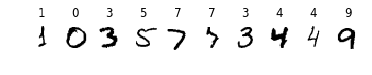

In [12]:
# Evaluate classification accuracy on the entire MNIST test set
def test_all(model):
    correct = 0
    for data, target in testloader:
        with torch.no_grad():        
            # run the data through the network
            output, h_fc1, h_conv2, h_conv1 = model(data)
        
        # compare prediction to ground truth
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    perc_correct = 100. * correct / len(testloader.dataset)
    return perc_correct

# Show the network's predicted class for an arbitrary set of `nshow` images from the MNIST test set
def test_viz(model, nshow=10):
    
    # grab a random subset of the data 
    testiter = iter(testloader)
    images, target = testiter.next()
    perm = np.random.permutation(images.size()[0])
    sel = torch.LongTensor(perm[:nshow])
    images = images[sel]
    with torch.no_grad():
        data = images
    
    # get predictions from the network
    output, h_fc1, h_conv2, h_conv1 = model(data)
    pred = output.data.max(1, keepdim=True)[1]
    pred = pred.numpy().flatten()
    # plot predictions along with the images
    for i in range(nshow):
        ax = plt.subplot(1, nshow, i+1)
        imshow(utils.make_grid(images[i]))
        plt.axis('off')
        plt.title(str(pred[i]))
        
def error_analysis_viz(model, digit, nshow=10):
    plt.figure()
    shown = 0
    for data in testloader:
        images, labels = data
        images_d = images[labels == digit]
        labels_d = labels[labels == digit]
        with torch.no_grad():
            data = images_d
        outputs = model(data)[0]
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels_d).squeeze()
        pred = predicted.numpy().flatten()
        for i in range(labels_d.shape[0]):
            if not c[i]:
                ax = plt.subplot(1, nshow, shown+1)
                imshow(utils.make_grid(images_d[i]))
                plt.axis('off')
                plt.title(str(pred[i]))
                shown += 1
                if shown == nshow:
                    return
            

# Display an image from the MNIST data set
def imshow(img):
#     print(img)

    img = img / 2 + 0.5     # unnormalize
    img = 1-img # invert
#     print(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

checkpoint = torch.load('models/convnet_mnist_pretrained_3layer_arch.pt')
model = Net()
model.load_state_dict(checkpoint)

model.eval()
print('Convnet has been loaded successfully.')
print('Running through the test set...')
test_acc = test_all(model)
print(' Accuracy on the test set is %.2f percent correct!' % test_acc)
print("")
print("Here are some predictions from the network.")
print("The images are shown below their predicted class labels.")
test_viz(model)



We may want to know what the network performed well or poorly at. The error analysis function gives you somewhat of a way to do that - e.g, try running the code below:

Some errors for 8s.


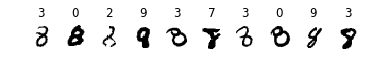

In [56]:
print("Some errors for 8s.")
error_analysis_viz(model, 8)

<div class="alert alert-success">You might want to look at how well the network performs on specific digits, as well as what it mixes up. Complete the code below to print out the accuracy on each digit, as well as a confusion matrix (read the comments below to learn what a confusion matrix is).</div>

In [9]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
confusion_matrix = np.zeros([10,10]) # you can access this just like a two-dimensional list
count = 0
for data in testloader:
    images, labels = data
    outputs = model(images)[0]
    _, predicted = torch.max(outputs.data, 1)
    pred = predicted.squeeze() # This variable stores the predicted classes
    
    # Loop through below to compute accuracies - you'll want to modify the variables so they store the following:
    # class_correct: this list should represent how many total instances of each digit were correct. 
    #                 E.g. class_correct[3] is a count of how many 3s the network classified correctly
    # class_total: this list should represent how many total instances of each digit were classified. 
    #               E.g. class_total[3] is a count of how many 3s the network was asked to classify
    # confusion_matrix: this matrix represents both what the network was actually trying to classify   
    #               and the prediction it made. The number in the i-th row, j-th column is the count
    #               of how many of digit i the network classified as digit j. (Note: we're starting our counting at zero since we classify 0-9)
    # Add your code below
    for i in range(len(labels)):
        # add for total 
        class_total[labels[i]] += 1
        if pred[i] == labels[i]:
            # if match add to correct
            class_correct[pred[i]] += 1
        # add numbers to confusion matrix
        act = labels[i]
        guess = pred[i]
        confusion_matrix[act][guess] += 1
            
    
# The loop below should print out the accuracy for each digit
for i in range(10):
     # max is to prevent a divide by 0 error if you have 0 images in a class
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / max(class_total[i],1)))
print(class_total)
# Modify your confusion matrix so the the i-th row, j-th column  now represents the proportion of
# digit i that were categorized as digit j. E.g., if there were 10 zeros and the network classified
# three of them as eights, then the entry in the zeroeth row, eighth column would be 3/10 = .3.
# Add your code below
for i in range(len(confusion_matrix)):
    # divide each entry in the matrix by the
    # class total value by the number
    confusion_matrix[i] = np.divide(confusion_matrix[i], class_total[i])



# This code prints out your confusion matrix with each number having up to 3 digits past the decimal.
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
print(confusion_matrix)
   


Accuracy of     0 : 97 %
Accuracy of     1 : 98 %
Accuracy of     2 : 91 %
Accuracy of     3 : 95 %
Accuracy of     4 : 95 %
Accuracy of     5 : 93 %
Accuracy of     6 : 96 %
Accuracy of     7 : 92 %
Accuracy of     8 : 93 %
Accuracy of     9 : 92 %
[980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0]
[[0.974 0.    0.001 0.002 0.    0.002 0.009 0.002 0.009 0.   ]
 [0.    0.986 0.004 0.002 0.001 0.    0.003 0.    0.005 0.   ]
 [0.006 0.002 0.92  0.017 0.01  0.001 0.008 0.013 0.024 0.   ]
 [0.    0.002 0.008 0.951 0.    0.012 0.    0.013 0.012 0.002]
 [0.    0.001 0.002 0.    0.957 0.    0.011 0.001 0.007 0.02 ]
 [0.004 0.002 0.001 0.024 0.001 0.939 0.008 0.001 0.018 0.001]
 [0.007 0.004 0.    0.    0.009 0.006 0.967 0.    0.006 0.   ]
 [0.    0.008 0.022 0.007 0.002 0.    0.    0.924 0.006 0.031]
 [0.006 0.    0.003 0.014 0.005 0.004 0.009 0.007 0.937 0.013]
 [0.007 0.007 0.004 0.009 0.018 0.008 0.    0.011 0.014 0.923]]


<div class="alert alert-success">What errors does the network make most often? Intuitively, any ideas why it might make these errors? Explain what you see in the confusion matrix, being specific about what the matrix tells you and using the error visualization above to try to explain at least two common misclassifications.</div>

The biggest errors that the returns are the bidirectional misidentification of 9s and 4s and 9s and 7s. In addition, 2s and 3s get bidirectionally confused. One interesting confusion is that 4s are more often identified as 6s than 6s as 4s. The first mentioned confusions are very logical. 9s, 4s, and 7s all share a single lower line with slightly differing upper halves. In other words, epecially with the irregularity of handwriting, they all share a major feature. Keep in mind that these errors are in the single digit percent, which makes sense as their uppers **do** have significant difference.

Another error, probably owing to similar cause is the confusion of 3 with 3. Both have similar uppers, but dissimilar lowers. The neural network is identifying these common features.

<div class="alert alert-success">The code below is the same neural network definition as above. It will save your network after training, and then the cell below that will compute the accuracy of your new network on the test set. Try modifying the architecture of the neural network in some way (e.g., the number of channels used in a convolution or the number of convolution layers, among other possibilities), and then explain what modification you made, what that means (e.g., if you changed the number of channels, explain what that means in terms of the neural network architecture), and your prediction for how the neural network accuracy will change, explaining your prediction based on what you know about neural neworks. Then, report the actual accuracy of your modified network on the test set.</div>

In [80]:
class ModifiedNet(nn.Module):
    def __init__(self):
        super(ModifiedNet, self).__init__()
        self.inputsize = 28
        channels_conv1 = 10
        channels_conv2 = 20

        kernel_size1 = 5
        padding1 = (kernel_size1-1)//2
        self.conv1 = nn.Conv2d(1, channels_conv1, kernel_size=kernel_size1, padding = padding1)
        self.pool = nn.MaxPool2d(2, 2)
        kernel_size2 = 3
        padding2 = (kernel_size2-1)//2
        self.conv2 = nn.Conv2d(channels_conv1, channels_conv2, kernel_size=kernel_size2, padding = padding2)
        
        output_size_one_dim= int(((self.inputsize+2*padding1-(kernel_size1-1))/2 +2*padding2-(kernel_size2-1))//2)
        self.fc1size=channels_conv2*output_size_one_dim**2
        self.fc1 = nn.Linear(self.fc1size, 50) # 50 hidden units in first fully-connected layer
        self.fc2 = nn.Linear(50, 10) # 10 output units
    
    def forward(self, x):

        # first convolutional layer
        h_conv1 = self.conv1(x)
        h_conv1 = F.relu(h_conv1)

        h_conv1_pool = self.pool(h_conv1)

        # second convolutional layer
        h_conv2 = self.conv2(h_conv1_pool)
        h_conv2 = F.relu(h_conv2)

        h_conv2_pool = self.pool(h_conv2)

        # fully-connected layer
        h_fc1 = h_conv2_pool.view(-1, self.fc1size) # this reshapes the tensor, so it's flat to give as input to the fc layer    
        h_fc1 = self.fc1(h_fc1)
        h_fc1 = F.relu(h_fc1)

        # classifier output
        output = self.fc2(h_fc1)
        output = F.log_softmax(output, dim=1)

        return output, h_fc1, h_conv2, h_conv1

modified_model = ModifiedNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modified_model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = modified_model(inputs)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')
# The line below saves your model. This allows you to avoid
# having to retrain the model every time you re-open your notebook.
torch.save(modified_model.state_dict(), 'models/convnet_mnist_pretrained_modified_arch.pt')


[1,   100] loss: 2.291
[1,   200] loss: 2.253
[1,   300] loss: 2.161
[1,   400] loss: 1.844
[1,   500] loss: 1.070
[1,   600] loss: 0.603
[2,   100] loss: 0.449
[2,   200] loss: 0.359
[2,   300] loss: 0.338
[2,   400] loss: 0.312
[2,   500] loss: 0.283
[2,   600] loss: 0.257
Finished Training


In [81]:
modified_network_dict = torch.load('models/convnet_mnist_pretrained_modified_arch.pt')
modified_model =ModifiedNet()
modified_model.load_state_dict(modified_network_dict)

modified_model.eval()
print('Convnet has been loaded successfully.')
print('Running through the test set...')
test_acc = test_all(modified_model)
print(' Accuracy on the test set is %.2f percent correct!' % test_acc)

Convnet has been loaded successfully.
Running through the test set...
 Accuracy on the test set is 92.00 percent correct!


We modified the size of the kernels each of our convolution layers. By making the kernels smaller, we are basically saying that each feature has less of a relation with its surroundings; if we made our kernels 1px, we'd be assuming that each kernel essentially has no effect on its surroundings. Making the kernels very big on the other hand conflicts with the assumption we make(and what makes CNNs helpful) that features locally present will be useful in all places. Since we made our kernels smaller, we predict that the accuracy will actually go down slightly. We are not changing the kernel sizes by extreme values(making them 1px), but we are shrinking them, so the model now views each pixel as having slightly less of an effect on other pixels. As you can see above, our prediction roughly is reflected by the accuracy of the network. 

## Selecting digits for similarity analysis

Here are two more useful functions: `get_random_subset` and `plot_image_pairs.`

As mentioned, we are looking at within-class similarity comparisons (e.g., comparing two different images of the digit '8'). The function `get_random_subset` generates a set of random images pairs from a particular image class `digit_select` from the MNIST test set. The number of random pairs can be set by `npairs`. 

The other function is `plot_image_pairs` which visualizes each of the random image pairs. The pairs are input as two list of image tensors, where images with the same index are paired.

In [9]:
def get_random_subset(digit_select, npairs=20):
    # digit_select: which digit do we want to get images for?
    testiter = iter(testloader)
    images, target = testiter.next()
    print("images:",images.shape)

    indices = np.flatnonzero(target.numpy() == digit_select)    
    np.random.shuffle(indices)
    print("indices:",indices.shape)
    indx1 = torch.LongTensor(indices[:npairs])
    indx2 = torch.LongTensor(indices[npairs:npairs*2])
    images1 = images[indx1]
    images2 = images[indx2]
    plt.figure(1,figsize=(4,40))
    plot_image_pairs(images1,images2)
    return images1, images2

def plot_image_pairs(images1,images2,scores_net=[],scores_people=[]):
    # images1 : list of images (each image is a tensor)
    # images2 : list of images (each image is a tensor)
    # scores_net (optional) : network similarity score for each pair
    # scores_people (optional) : human similarity score for each pair
    npairs = images1.size()[0]
    print("npairs:", npairs)
    print(" images2.size()[0]:",  images2.size()[0])

    assert images2.size()[0] == npairs
    for i in range(npairs):
        ax = plt.subplot(npairs, 1, i+1)
        imshow(utils.make_grid([images1[i], images2[i]]))
        mytitle = ''
        if len(scores_net)>0:
            mytitle += 'net %.2f, ' % scores_net[i] 
        if len(scores_people)>0:
            mytitle += 'human. %.2f' % scores_people[i]
        if mytitle:
            plt.title(mytitle)

Here is code for sampling 20 random pairings of images of the digit '8' (or whichever digit you set `digit_select` to). Run to sample the pairings and then visualize them (you may have to scroll). 

<div class="alert alert-info">
To save or print out the image pairs, which will be helpful later in the assignment, you can right click and save the output as an image.
</div>

In [10]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1000,
                                         shuffle=False, num_workers=2)

images: torch.Size([1000, 1, 28, 28])
indices: (89,)
npairs: 20
 images2.size()[0]: 20


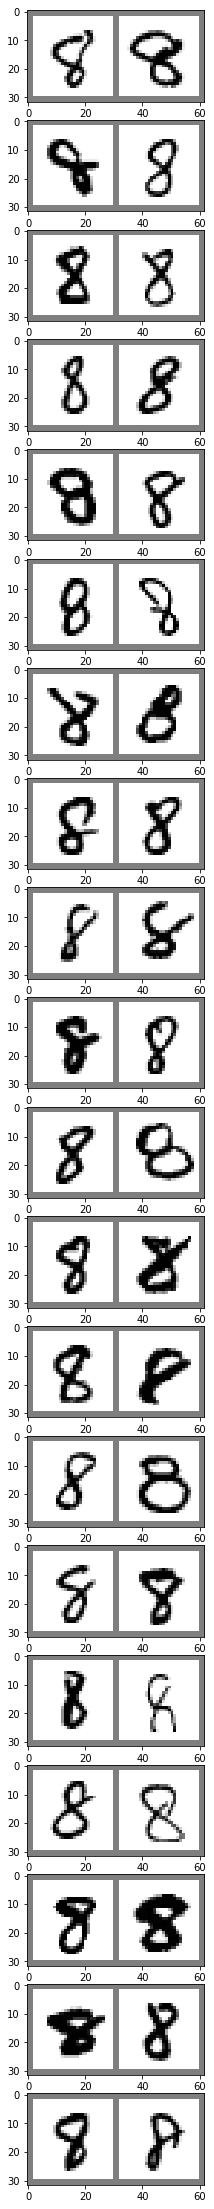

In [13]:
images1_digit8,images2_digit8 = get_random_subset(digit_select=8, npairs = 20)

Here is code for sampling 20 random pairings of another digit besides 8. Choose at random, or pick a digit yourself!

images: torch.Size([1000, 1, 28, 28])
indices: (110,)
npairs: 20
 images2.size()[0]: 20


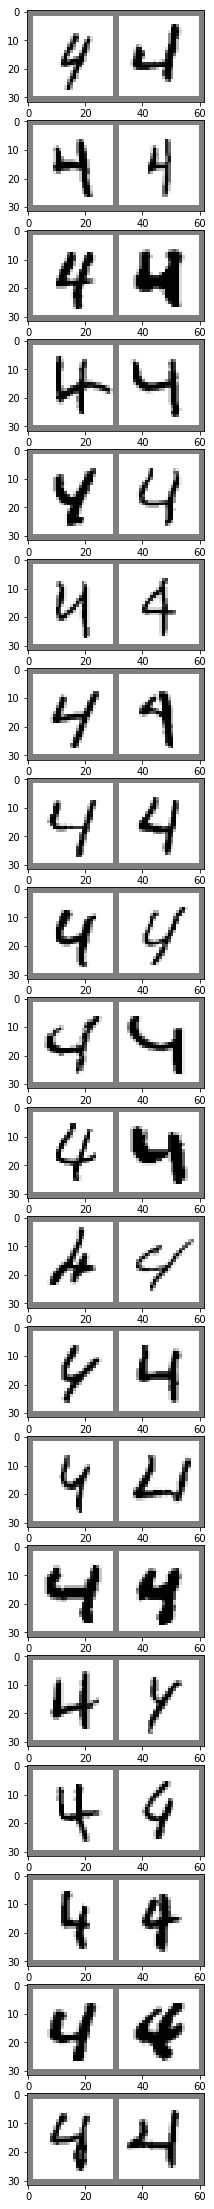

In [14]:
digit_select = 4#random.choice([0,1,2,3,4,5,6,7,9])
images1_digit_other,images2_digit_other = get_random_subset(digit_select, npairs = 20)

## Computing similarity judgments with the network
To get predictions out of the network, we take the hidden representation at a particular layer as a representation of an image. To compute the similarity between two images, we get the two hidden vectors and compare them with the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) metric.

The function `get_sim_judgments` takes two lists of images and computes the similarity between each pair. Using the `layer` parameter, you can choose between the fully connected layer (`fc`), first convolutional layer (`conv1`), or second convolutional layer (`conv2`).

The function `normalize` rescales a vector to have a minimum value of 0 and maximum value of 1.

In [15]:
# re-scale a vector to have a minimum value of 0, maximum of 1
def normalize(v):
    # v : numpy vector
    v = v - v.min()
    v = v / v.max()
    return v

# Compute convnet similarity for each pair of images
def get_sim_judgments(images1,images2,layer='fc'):
    # images1 : list of N images (each image is a tensor)
    # images2 : list of N images (each image is a tensor)
    # layer : which layer do we want to use? fully connected ('fc'), 
    #         first convolutional ('conv1'), or second convolutional ('conv2')
    #
    # Return
    #  v_sim : N-dimensional vector
    N = images1.size()[0] # number of pairs
    assert N == images2.size()[0]
    with torch.no_grad():
        output_1, h_fc1_1, h_conv2_1, h_conv1_1 = model(images1)
        output_2, h_fc1_2, h_conv2_2, h_conv1_2 = model(images2)
    
    # grab the tensors from the appropriate layer
    if layer=='fc':
        T1 = h_fc1_1
        T2 = h_fc1_2
    elif layer=='conv1':
        T1 = h_conv1_1
        T2 = h_conv1_2
    elif layer=='conv2':
        T1 = h_conv2_1
        T2 = h_conv2_2
    else:
        raise Exception('Layer parameter has unrecognized value')
    
    # flatten the tensors for each image
    T1 = T1.data.numpy().reshape(N,-1)
    T2 = T2.data.numpy().reshape(N,-1)

    v_sim = np.zeros(N)
    for i in range(N):
        v1 = T1[i,:]
        v2 = T2[i,:]
        v_sim[i] = 1-cosine(v1,v2) # using cosine distance between the vectors 
    return v_sim

## EDIT THIS CODE TO SWITCH BETWEEN LAYERS ('fc', 'conv1', and 'conv2')
v_sim_net_digit8 = get_sim_judgments(images1_digit8,images2_digit8,'fc')
print("Similarity ratings from the neural network the for digit 8:")
print(v_sim_net_digit8)
v_sim_net_digit_other = get_sim_judgments(images1_digit_other,images2_digit_other,'fc')
print("Similarity ratings from the neural network for the other digit:")
print(v_sim_net_digit_other)

Similarity ratings from the neural network the for digit 8:
[0.86905873 0.87030238 0.9638359  0.97120506 0.97032118 0.88790935
 0.80392236 0.90509909 0.8853569  0.92778474 0.88462472 0.8334291
 0.90408963 0.87766421 0.86402583 0.87698483 0.88526499 0.95360231
 0.88110441 0.95029509]
Similarity ratings from the neural network for the other digit:
[0.85979521 0.96514249 0.95880646 0.91954327 0.93664044 0.93232113
 0.88935381 0.96806115 0.98406655 0.91718751 0.95743716 0.81425202
 0.90861738 0.68277758 0.96973318 0.77297646 0.93673396 0.92579937
 0.95977622 0.94764656]


<div class="alert alert-success">
Go through the following steps for both the digit '8' and another digit of your choice:
<ol>
<li> *Get judgments from the network.* Run all of the code above to sample a list of 20 pairs of images for that digit. For each pair, get a measure of the network's similarity between the images as measured on the fully-connected `fc` layer. (You may have already done all of this.)</li>
<li> *Get judgments from people.* Ask two people to rate the same image pairs on a 1 (least similar) to 10 (most similar) scale, using the question "How similar do these two images look to you?" An easy way to collect the data is to print out the image pairs (you can right-click and save the jupyter notebook figures as images). Ask your participant to write their ratings next to each pair. Enter the ratings in the arrays `ratings_human_1_digit8`, `ratings_human_2_digit8`, `ratings_human_1_digit_other`, and `ratings_human_2_digit_other` below. One participant can be you, but the other needs to be someone else! (If you're working in a partnership, it can be you and your partner.)</li>
<li> *Compare.* Run the code below to compute the correlation coefficient and scatter plot.</li>
<li> *Analyze and write-up.* How well does the network do at predicting the similarity ratings? What is it capturing? What is it not capturing?</li>
<li> *Try different layers of the network*. Run the analysis again with other layers of the convnet, `conv1` and `conv2`. Does this change your results? Which layer provides the best account?</li>
<li> *Compare across digits*. Once you've done the steps above for both digits, add to your writeup so that it's clear whether your network shows similar patterns across the two digits for which layer provides the best account and what types of similarity the network is able to capture, or if it's different, why you think the differences might occur.</li>
</ol>
<div class="alert alert-info">
Don't worry if your fit isn't very good! A convnet is very far from a perfect account of human similarity ratings. I had reasonable success with the `8` digit but I wouldn't except a correlation higher than r=0.6. This assignment is not graded on how good the fit is, but rather how thorough your analysis is.
</div>

<div class="alert alert-success">
You should write a written response that responds to the *analyze and write-up* portion above in the cell below. You are welcome to modify the analysis code below that however you wish - it will not be graded except to check that the data are present. In your written response, you should include the information specified above, as well as these statistics and plots:
<br>
<ul>
<li> The relevant correlations (for each layer `fc`, `conv1`, and `conv2`) - the analysis code will calculate the correlation for you, based on the similarity from the network calculated above (so you'll need to change the layer above to compare to a different layer).</li>
<li> A scatter plot of the human similarity rating and the network similarity rating (for each layer `fc`, `conv1`, and `conv2`). </li>
<li> Any particularly relevant digit pairs with the human and network similarities (the analysis code below will produce these - you can save them using right click and then Save Image, and then include the image in your markdown.  </li>
<ul>
</div>


Based on two participants, the major difference we experienced with the neural network was on dissimilarity. It seemed that humans were way more discerning about similarity than the network. The human data rated most comparisons lower than the each layer.(see Graphs below). What we **do** know is that both human and network were making in-class comparisons. We think that this speaks to the way that CNNs and humans weigh and approach features. First, when looking at the graphs and the output below,it seems that one or two apppear to be rated as 0 by humans, which doesn't seem possible, but after dismissing these outliers, we can see a clear correlation. In the first 10 comparisons of 8s, we can see the human similarities matching in shape, but not in similarity. Both machine and human rate the various comparisons

Correlation between net and human similarity ratings: r =
0.467
npairs: 20
 images2.size()[0]: 20


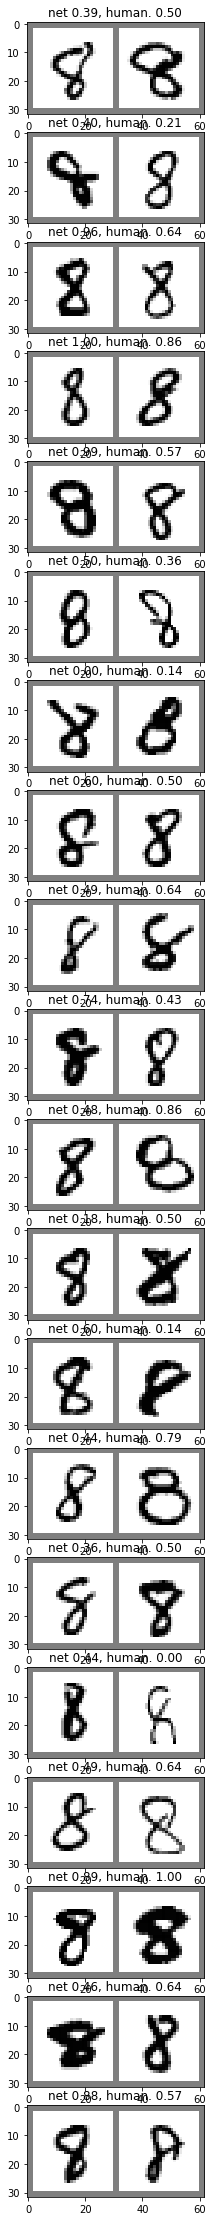

In [26]:
# YOUR PARTICIPANT RATINGS GO HERE
ratings_human_1_digit8 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], dtype='float')
ratings_human_2_digit8 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], dtype='float')
# data from Patty and Ben
ratings_human_1_digit8 = np.array([6,3,5,7,5,4,2,5,6,5,7,5,4,8,5,2,6,9,7,7], dtype='float')
ratings_human_2_digit8 = np.array([5,4,8,9,7,5,4,6,7,5,9,6,2,7,6,2,7,9,6,5], dtype='float')
# Analysis code
ratings_human_mean_digit8 = (ratings_human_1_digit8 + ratings_human_2_digit8)/2

v_sim_net_norm8 = normalize(v_sim_net_digit8)
v_sim_human_norm8 = normalize(ratings_human_mean_digit8)

# Correlation is a number in [-1,1] that tells you whether two variables
# (here, the network and human similarity) are related to one another. A
# negative value means that when one variable goes up, the other tends to go down;
# a positive value means that when one variable goes up, the other tends to go up
# too; a zero value means the two variables are unrelated.
# (Feel free to read more on wikipedia if you're interested: https://en.wikipedia.org/wiki/Correlation_and_dependence)

print("Correlation between net and human similarity ratings: r ="),
print(round(np.corrcoef(v_sim_net_norm,v_sim_human_norm)[0][1],3))

# pairs with similarity ratings
plt.figure(2,figsize=(4,40))
plot_image_pairs(images1_digit8,images2_digit8,v_sim_net_norm,v_sim_human_norm)
plt.show()

Correlation between net and human similarity ratings: r =
0.467
npairs: 20
 images2.size()[0]: 20


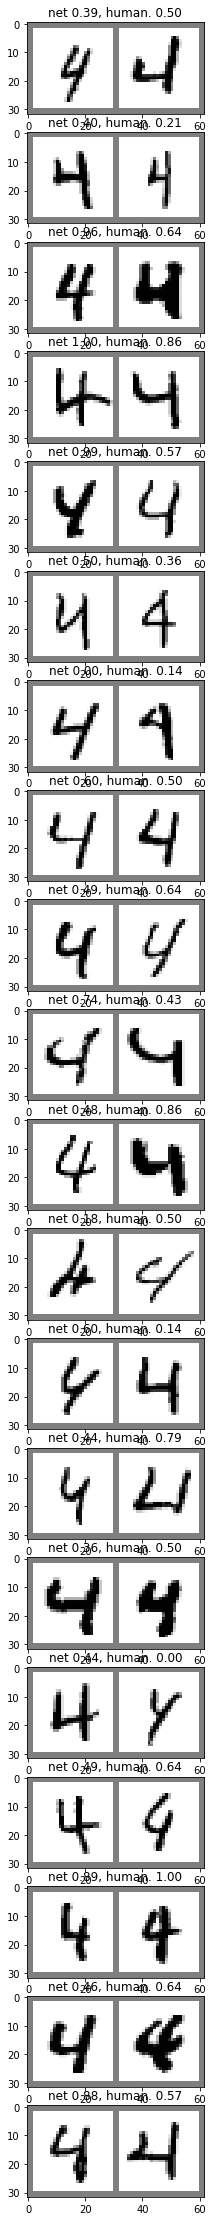

In [46]:
# YOUR PARTICIPANT RATINGS GO HERE
ratings_human_1_digit_other = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], dtype='float')
ratings_human_2_digit_other = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], dtype='float')
# data from Patty and Ben
ratings_human_1_digit_other = np.array([4,7,6,5,5,3,4,8,6,7,5,4,6,5,8,5,6,7,5,7], dtype='float')
ratings_human_2_digit_other = np.array([6,9,7,5,3,3,5,8,7,8,4,3,5,4,8,6,4,4,4,6], dtype='float')
# Analysis code
ratings_human_mean_digit_other = (ratings_human_1_digit_other + ratings_human_2_digit_other)/2

v_sim_net_norm4 = normalize(v_sim_net_digit_other)
v_sim_human_norm4 = normalize(ratings_human_mean_digit_other)

# Correlation is a number in [-1,1] that tells you whether two variables
# (here, the network and human similarity) are related to one another. A
# negative value means that when one variable goes up, the other tends to go down;
# a positive value means that when one variable goes up, the other tends to go up
# too; a zero value means the two variables are unrelated.
# (Feel free to read more on wikipedia if you're interested: https://en.wikipedia.org/wiki/Correlation_and_dependence)
print("Correlation between net and human similarity ratings: r ="),
print(round(np.corrcoef(v_sim_net_norm,v_sim_human_norm)[0][1],3))

# pairs with similarity ratings
plt.figure(2,figsize=(4,40))
plot_image_pairs(images1_digit_other,images2_digit_other,v_sim_net_norm,v_sim_human_norm)
plt.show()

[]

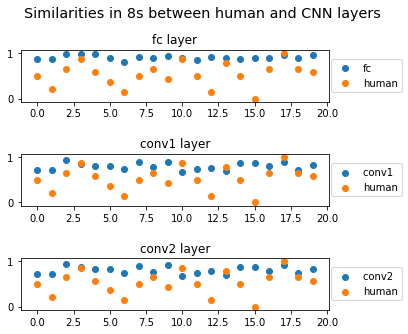

In [72]:
# Scatter plot each layer.
sim_8_fc = get_sim_judgments(images1_digit8,images2_digit8,'fc')
sim_8_conv1 = get_sim_judgments(images1_digit8,images2_digit8,'conv1')
sim_8_conv2 = get_sim_judgments(images1_digit8,images2_digit8,'conv2')
fig = plt.figure()
st = fig.suptitle("Similarities in 8s between human and CNN layers", fontsize="x-large")
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_title("fc layer")
ax1.scatter([i for i in range(len(sim_8_fc))], sim_8_fc, label="fc")
ax1.scatter([i for i in range(len(sim_8_fc))], v_sim_human_norm8, label="human")
ax1.legend(loc=7, bbox_to_anchor=(1.25, .5))

ax2.set_title("conv1 layer")
ax2.scatter([i for i in range(len(sim_8_fc))], sim_8_conv1, label="conv1 ")
ax2.scatter([i for i in range(len(sim_8_fc))], v_sim_human_norm8, label="human")
ax2.legend(loc=7, bbox_to_anchor=(1.25, .5))

ax3.set_title("conv2 layer")
ax3.scatter([i for i in range(len(sim_8_fc))], sim_8_conv2, label="conv2 ")
ax3.scatter([i for i in range(len(sim_8_fc))], v_sim_human_norm8, label = "human")
ax3.legend(loc=7, bbox_to_anchor=(1.25, .5))
fig.tight_layout()

plt.subplots_adjust(hspace = 1,top=1)
st.set_y(1.15)

plt.plot()


[]

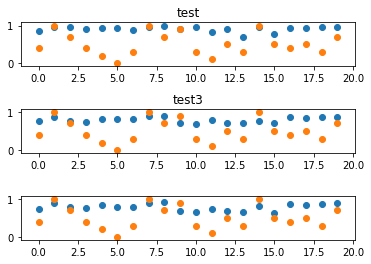

In [48]:
# Scatter Plot each layer.
sim_4_fc = get_sim_judgments(images1_digit_other,images2_digit_other,'fc')
sim_4_conv1 = get_sim_judgments(images1_digit_other,images2_digit_other,'conv1')
sim_4_conv2 = get_sim_judgments(images1_digit_other,images2_digit_other,'conv2')

plt.subplot(3, 1, 1)
plt.title("test")
plt.scatter([i for i in range(len(sim_4_fc))], sim_4_fc)
plt.scatter([i for i in range(len(sim_8_fc))], v_sim_human_norm4)
plt.subplot(3, 1, 2)
plt.title("test3")
plt.scatter([i for i in range(len(sim_8_fc))], sim_4_conv1)
plt.scatter([i for i in range(len(sim_8_fc))], v_sim_human_norm4)
plt.subplot(3, 1, 3)
plt.scatter([i for i in range(len(sim_8_fc))], sim_4_conv2)
plt.scatter([i for i in range(len(sim_8_fc))], v_sim_human_norm4)
plt.subplots_adjust(hspace = 1)
plt.plot()